In [1]:
import pandas as pd
import glob
import datetime
import metpy.calc as mpcalc
from metpy.units import units
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from pyhdf import SD
import numpy as np
import math
import pint
from pydoc import help
from pyhdf.SD import *
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk
%matplotlib inline

In [2]:
# Set display options to show all rows and columns in dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
def find_ll_index(latarray,findlat):
    latindex = np.where(latarray == findlat)
    lat_pos = latindex[0][0]
    return lat_pos

In [27]:
# Define a function to map month numbers to seasons
def assign_season(month):
    if month in [3,4,5]:
        return 'MMA'
    elif month in [6,7,8]:
        return 'JJA'
    elif month in [9,10,11]:
        return 'SON'
    else:
        return 'DJF'

In [3]:
#loop to read in soil moisture data
soildata = []
bugs=0
path = "../../data/rong1/climate_fu/Data/DOEARM/sgp/okmsoilX1"
soil_list = sorted(glob.glob(path + "/*.nc"))
for file in soil_list:
    try:
        s = xr.open_dataset(file)
        #print(s.encoding['source'])
        soildata.append(s)
    except Exception as e:
        print(f"Error opening file: {file}")
        bugs+=1
        print(e)

Error opening file: ../../data/rong1/climate_fu/Data/DOEARM/sgp/okmsoilX1/all_variates.nc
[Errno -101] NetCDF: HDF error: b'/data/rong1/climate_fu/Data/DOEARM/sgp/okmsoilX1/all_variates.nc'
Error opening file: ../../data/rong1/climate_fu/Data/DOEARM/sgp/okmsoilX1/sgpokmsoilX1.c1.20010101_20200101_05cm.nc
[Errno -101] NetCDF: HDF error: b'/data/rong1/climate_fu/Data/DOEARM/sgp/okmsoilX1/sgpokmsoilX1.c1.20010101_20200101_05cm.nc'
Error opening file: ../../data/rong1/climate_fu/Data/DOEARM/sgp/okmsoilX1/sgpokmsoilX1.c1.20010101_20200101_25cm.nc
[Errno -101] NetCDF: HDF error: b'/data/rong1/climate_fu/Data/DOEARM/sgp/okmsoilX1/sgpokmsoilX1.c1.20010101_20200101_25cm.nc'


In [42]:
soildata[0].variables['lat']

<xarray.Variable (station_number: 114)>
array([34.80833, 34.79851, 34.58722, 36.7797 , 34.22438, 34.91418, 34.1922 ,
       36.07204, 34.0144 , 36.80253, 35.40185, 35.96305, 36.75443, 36.69256,
       35.17156, 36.41201, 35.7805 , 36.83129, 36.63459, 33.89376, 35.5915 ,
       34.8497 , 34.9924 , 36.02866, 36.2619 , 34.60896, 35.65282, 36.74813,
       35.54615, 35.03236, 36.3172 , 34.65657, 34.22321, 35.68001, 36.90987,
       33.92075, 35.54848, 35.20494, 35.30324, 36.26353, 36.84053, 36.72562,
       35.14887, 36.60183, 34.2392 , 35.84891, 35.74798, 35.84162, 35.48439,
       34.98971, 34.6855 , 36.85518, 34.03084, 33.83013, 36.4821 , 36.82937,
       34.52887, 35.8805 , 36.38435, 34.30876, 34.03579, 34.83592, 36.06434,
       36.1186 , 36.98707, 34.88231, 36.79242, 34.72921, 36.88832, 35.27225,
       34.31072, 36.8981 , 34.96774, 35.2556 , 36.74374, 36.03126, 35.43172,
       35.58211, 34.7155 , 36.36114, 35.99865, 35.7247 , 36.36914, 35.89904,
       36.3559 , 35.12275, 34.19365, 35.43815, 36.19033, 35.36492, 36.4153 ,
       36.59749, 35.54208, 35.26527, 36.12093, 34.87642, 34.5661 , 35.97235,
       34.7107 , 34.43972, 34.33262, 35.8397 , 36.77536, 34.3647 , 34.98224,
       35.84185, 34.16775, 35.5083 , 35.47298, 36.011  , 34.90092, 34.98426,
       36.42329, 36.51806], dtype=float32)
Attributes:
    long_name:      North latitude
    units:          degree_N
    valid_min:      -90.0
    valid_max:      90.0
    standard_name:  latitude

In [18]:
#seek to calculate average JJA soil moisture for each year from 1998-2020 for one station
#lat/lon index 18 = 36.63459,-96.81046
#36.610001,-97.489998 --> for surface temps, find station closer to this

findlat = 36.75443
soil_tups = []
invalid_soil = []
for s in soildata:
    lat = s.variables["lat"].data
    lon = s.variables["lon"].data
    lat_lon_index = find_ll_index(lat,findlat)
    bt = s.variables["base_time"].data
    v_water = s.variables["fractional_water_index"].data
    #extract first observation of day (v_water[0]) at 25 cm (v_water[0][1])
    #and at specific station (v_water[0][1][lat_lon_index])
    v_25cm_first_obs = v_water[0][1][lat_lon_index]
    if 1 >= v_25cm_first_obs >= 0:
        tup = (bt, v_25cm_first_obs)
        soil_tups.append(tup)
    else:
        invalid_soil.append(v_25cm_first_obs)

In [71]:
soildata[0].variables['fractional_water_index'].data[0][1][13]

0.89065903

(-96.81046, 36.63459)


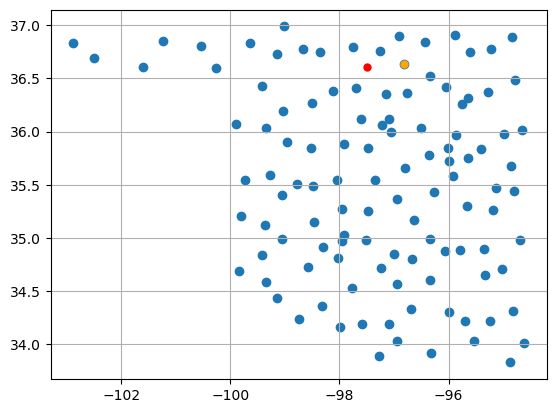

In [77]:
lat = soildata[0].variables['lat'].data
lon = soildata[0].variables['lon'].data
sgp = (36.607322,-97.487643)
closest = (lon[18],lat[18])
plt.scatter(lon,lat)
plt.plot(closest[0],closest[1],marker='o',color='orange',markersize=5)
plt.plot(sgp[1], sgp[0], marker='o', color='red', markersize=5)
plt.grid()
print(closest)

Closest Point 1 (Index 12): (36.75442886352539, -97.2545166015625)
Closest Point 2 (Index 15): (36.412010192871094, -97.69393920898438)
Closest Point 3 (Index 66): (36.79241943359375, -97.74577331542969)
Closest Point 4 (Index 84): (36.355899810791016, -97.15306091308594)


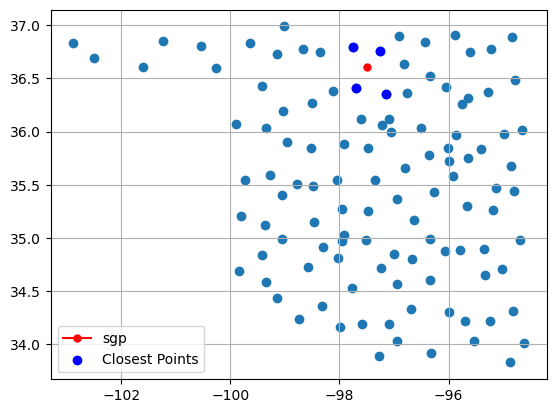

In [78]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance


# Calculate distances
distances = haversine(lat, lon, sgp[0], sgp[1])

# Find the four closest points
closest_points_indices = np.argsort(distances)[:4]
closest_points_lat = lat[closest_points_indices]
closest_points_lon = lon[closest_points_indices]

for i, index in enumerate(closest_points_indices):
    print(f"Closest Point {i + 1} (Index {index}): ({lat[index]}, {lon[index]})")

# Plot the results
plt.scatter(lon, lat)
plt.plot(sgp[1], sgp[0], marker='o', color='red', markersize=5, label='sgp')
plt.scatter(closest_points_lon, closest_points_lat, marker='o', color='blue', label='Closest Points')
plt.legend()
plt.grid()
plt.show()

sgp = (36.607322,-97.487643)

In [52]:
find_ll_index(36.75442886352539,lat)

12

In [29]:
#processing to group by season, and plot soil moisture change time series
#sets index to be date
soil_tups_df = pd.DataFrame(soil_tups, columns=['time','fwi'])

soildf = soil_tups_df.set_index("time")

#converts date column to Oklahoma time 
soildf.index = pd.to_datetime(soildf.index)
soildf.index = soildf.index - datetime.timedelta(hours=6)

soildf = soildf.sort_index()

#adding columns for year,month,day,hour
soildf['year'] = soildf.index.year
soildf['month'] = soildf.index.month
soildf['day'] = soildf.index.day
soildf['hour'] = soildf.index.hour

# Apply the function to create the "season" column
soildf['season'] = soildf['month'].apply(assign_season)

#season_lcls = lcl_df_11.groupby(['year', 'season'])['pressure'].mean()
avgsoil = soildf.groupby(['year', 'season'])['fwi'].agg(['mean', 'size']).rename(columns={'mean': 'mean_fractional_water_index', 'size': 'count_values'})

avgsoil = pd.DataFrame(avgsoil).reset_index()
avgsoil_jja = avgsoil[avgsoil['season'] == 'JJA'].reset_index()
avgsoil_mma = avgsoil[avgsoil['season'] == 'MMA'].reset_index()
avgsoil_son = avgsoil[avgsoil['season'] == 'SON'].reset_index()
avgsoil_djf = avgsoil[avgsoil['season'] == 'DJF'].reset_index()

all_soil_seasons = [avgsoil_jja, avgsoil_mma, avgsoil_son, avgsoil_djf]

<bound method _make_class_factory.<locals>.class_factory.<locals>.subcls.set of <AxesSubplot: title={'center': 'Average Soil Moisture'}, xlabel='Year', ylabel='degrees C'>>

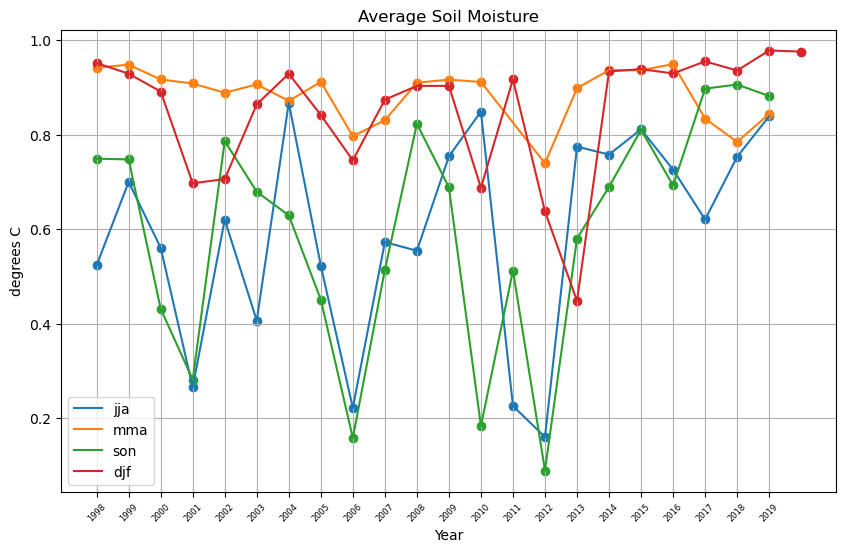

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

seasons = ['jja', 'mma', 'son', 'djf']

# Iterate over each season's DataFrame
for i, season_df in enumerate([avgsoil_jja, avgsoil_mma, avgsoil_son, avgsoil_djf]):
    season_df = season_df[season_df['count_values'] > 10]
    plt.scatter(season_df['year'], season_df['mean_fractional_water_index'])
    plt.plot(season_df['year'], season_df['mean_fractional_water_index'],label=seasons[i])
# Customize the plot
plt.grid(True)
ax.legend()
plt.xticks(avgsoil_jja['year'], rotation=45, fontsize=6)
ax.set_xlabel('Year')
ax.set_title("Average Soil Moisture")
ax.set_ylabel('degrees C')
ax.set

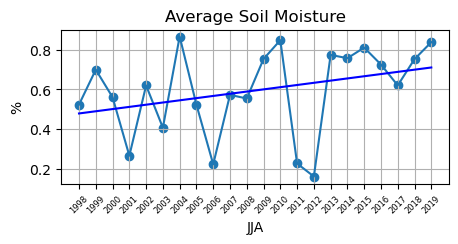

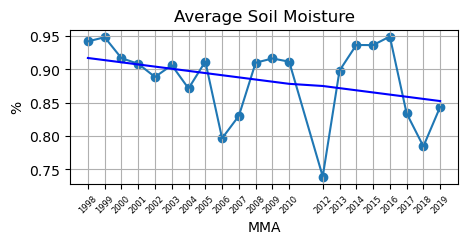

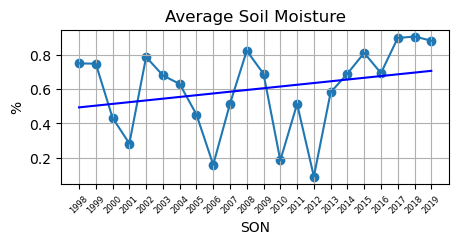

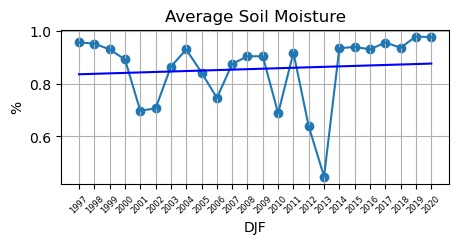

In [40]:
#plotting avgsoil seasonally
for df in all_soil_seasons:
    plt.figure(figsize=(5, 2))
    plt.scatter(df['year'], df['mean_fractional_water_index'])
    xlab = df.loc[0, 'season']
    plt.xlabel(xlab)
    plt.ylabel('%')
    plt.title('Average Soil Moisture')
    plt.xticks(df['year'], rotation=45, fontsize=6)

    plt.grid(True)

    # Adding trendline
    x = np.arange(len(df))
    y = df['mean_fractional_water_index']

    # Fit a linear regression model
    reg = LinearRegression()
    reg.fit(x.reshape(-1, 1), y)

    # Calculate the predicted y-values (trend line)
    y_pred = reg.predict(x.reshape(-1, 1))

    # Plotting the data and trend line
    plt.plot(df['year'], df['mean_fractional_water_index'], label='Data')
    plt.plot(df['year'], y_pred, color='blue', label='Trend Line')

    plt.show()